### 从头实现 Qwen2-0.5b with kvcache

从头开始实现Qwen2-0.5b，支持huggingface格式以safetensors为后缀的权重，并支持kvcache，进行自回归推理。

以 "If I have seen further, it is by standing" 作为输入的prompt，先进行prefill的并行运算，生成最后一个token并缓存 k 和 v，然后进行自回归生成，将前一次输出作为下一次输入，同时加载缓存的kvcache进行推理，逐个token生成"on the shoulders of giants."。


#### 加载分词器

In [591]:
from tokenizers import Tokenizer as TokenizerFast
import os

model_path = "../qwen/Qwen2-0_5B"

tokenizer = TokenizerFast.from_file(os.path.join(model_path, 'tokenizer.json'))
tokenizer.decode(tokenizer.encode("hello world!").ids)

'hello world!'

#### 读取模型
通常，读取模型文件往往取决于模型类的编写方式以及其中的变量名称。
但是由于我们是从头开始实现 qwen2，我们将一次读取一个张量。

In [592]:
from safetensors import safe_open
model = {}

with safe_open(os.path.join(model_path, "model.safetensors"), framework="pt", device="cpu") as f:
    count = 1
    for k in f.keys():
        model[k] = f.get_tensor(k)
        count += 1
        if count < 16:   # 仅显示部分权重及其shape，作为示例
            print(k, model[k].shape)

model.embed_tokens.weight torch.Size([151936, 896])
model.layers.0.input_layernorm.weight torch.Size([896])
model.layers.0.mlp.down_proj.weight torch.Size([896, 4864])
model.layers.0.mlp.gate_proj.weight torch.Size([4864, 896])
model.layers.0.mlp.up_proj.weight torch.Size([4864, 896])
model.layers.0.post_attention_layernorm.weight torch.Size([896])
model.layers.0.self_attn.k_proj.bias torch.Size([128])
model.layers.0.self_attn.k_proj.weight torch.Size([128, 896])
model.layers.0.self_attn.o_proj.weight torch.Size([896, 896])
model.layers.0.self_attn.q_proj.bias torch.Size([896])
model.layers.0.self_attn.q_proj.weight torch.Size([896, 896])
model.layers.0.self_attn.v_proj.bias torch.Size([128])
model.layers.0.self_attn.v_proj.weight torch.Size([128, 896])
model.layers.1.input_layernorm.weight torch.Size([896])


In [593]:
import json
with open(os.path.join(model_path, 'config.json'), "r") as f:   # 加载config文件，获取模型配置参数
    config = json.load(f)
config

{'architectures': ['Qwen2ForCausalLM'],
 'attention_dropout': 0.0,
 'bos_token_id': 151643,
 'eos_token_id': 151643,
 'hidden_act': 'silu',
 'hidden_size': 896,
 'initializer_range': 0.02,
 'intermediate_size': 4864,
 'max_position_embeddings': 131072,
 'max_window_layers': 24,
 'model_type': 'qwen2',
 'num_attention_heads': 14,
 'num_hidden_layers': 24,
 'num_key_value_heads': 2,
 'rms_norm_eps': 1e-06,
 'rope_theta': 1000000.0,
 'sliding_window': 131072,
 'tie_word_embeddings': True,
 'torch_dtype': 'bfloat16',
 'transformers_version': '4.40.1',
 'use_cache': True,
 'use_sliding_window': False,
 'vocab_size': 151936}

#### 我们使用这些配置推断模型的细节
1. 模型有24个 transformer layer；
2. 每个 multi-head attention 块有14个头
3. 词表大小是151936等等

In [594]:
import torch
dim = config["hidden_size"]
n_layers = config["num_hidden_layers"]
n_heads = config["num_attention_heads"]
n_kv_heads = config["num_key_value_heads"]
vocab_size = config["vocab_size"]
ffn_dim_multiplier = config["intermediate_size"]
norm_eps = config["rms_norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

#### 将文本转换为tokens

In [595]:
prompt = "If I have seen further, it is by standing"   #  generate "on the shoulders of giants."
tokens = tokenizer.encode(prompt).ids
print(tokens)  # 分词的id，就是实际模型的输入
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]  # 将ids解码出token，查看是否和promp是一样的
print(prompt_split_as_tokens)

[2679, 358, 614, 3884, 4623, 11, 432, 374, 553, 11259]
['If', ' I', ' have', ' seen', ' further', ',', ' it', ' is', ' by', ' standing']


#### 将token转换为对于的Embedding
原来的[10x1] tokens 现在变成了[10x896], 即 10 个长度为 896 的embedding向量，每个向量对应一个token。
<br>
<br>
**注意: 持续跟踪 shapes 变化，将会更容易理解所有的内容。**

In [596]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["model.embed_tokens.weight"])   # 加载Embedding层并拷贝权重赋值
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)   # 获取每个token的embedding表示
token_embeddings_unnormalized.shape

torch.Size([10, 896])

#### 然后使用RMS归一化embedding

请注意，经过这一步之后 shapes 不变，只是值被归一化。
<br>

另外我们需要一个 norm_eps（来自配置文件）避免出现将 rms 设置为 0 并导致除以 0 的意外情况。
<br>

这是公式:

In [597]:
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

#### 构建第一个Transformer层
首先进行归一化。我们从模型字典中访问 layer.0（这是第一层）。归一化之后 shapes 仍然是 [10x896]，与 embedding 相同但已归一化。

In [598]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["model.layers.0.input_layernorm.weight"])
token_embeddings.shape

torch.Size([10, 896])

#### 从头实现注意力机制
先加载第一个 Transformer 层的注意力头。
<br>

在理想情况下我们希望每个头单独拥有各自的 q，k，v 和 o，而实际上所有的 head 的权重是绑定在一起的，因为这样更有利于并行计算。因此我们可以将其全部展开。

In [599]:
print(
    model["model.layers.0.self_attn.q_proj.weight"].shape,
    model["model.layers.0.self_attn.q_proj.bias"].shape,
    model["model.layers.0.self_attn.k_proj.weight"].shape,
    model["model.layers.0.self_attn.k_proj.bias"].shape,
    model["model.layers.0.self_attn.v_proj.weight"].shape,
    model["model.layers.0.self_attn.v_proj.bias"].shape,
    model["model.layers.0.self_attn.o_proj.weight"].shape
)

torch.Size([896, 896]) torch.Size([896]) torch.Size([128, 896]) torch.Size([128]) torch.Size([128, 896]) torch.Size([128]) torch.Size([896, 896])


#### 展开 query 权重
下面我们将展开多个注意力头的 query，得到权重的 shapes 为 [14x64x896]，偏置的 shapes 为 [14, 64]
<br>

这里的 14 是 qwen2-0.5b 的注意力头数量，64 是 query 向量的大小，896 是 token 嵌入的大小

In [600]:
q_layer0 = model["model.layers.0.self_attn.q_proj.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.reshape(n_heads, head_dim, dim)
print(q_layer0.shape)

q_layer0_bias = model["model.layers.0.self_attn.q_proj.bias"]
q_layer0_bias = q_layer0_bias.reshape(n_heads, -1)
print(q_layer0_bias.shape)

torch.Size([14, 64, 896])
torch.Size([14, 64])


#### 实现第一层的第一个头
取第一个层的第一个头的 query 权重和偏置矩阵，shape 分别为 [64x896] 和 [64]

In [601]:
q_layer0_head0 = q_layer0[0]
q_layer0_bias_head0 = q_layer0_bias[0]
q_layer0_head0.shape, q_layer0_bias_head0.shape

(torch.Size([64, 896]), torch.Size([64]))

#### 现在将 query 权重与 token 嵌入相乘，并和偏置相加，以获得每个 token 的 query
这里可以看到得到的 shape 是 [10x64]，这是因为我们有 10 个 token，每个 token 有一个长度为 64 的 query

In [602]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T) + q_layer0_bias_head0
q_per_token.shape

torch.Size([10, 64])

#### keys (和 queries 几乎一模一样)
&gt; keys 生成的 key 向量的维度也是 64
<br>
&gt; keys 的权重只有 query 的 1/7，因为 keys 的权重在 7 个头之间共享，以减少计算量。具体请参考 GQA
<br>
&gt; keys 也像 query 一样被旋转以添加位置信息

In [603]:
k_layer0 = model["model.layers.0.self_attn.k_proj.weight"]
k_layer0 = k_layer0.reshape(n_kv_heads, k_layer0.shape[0]// n_kv_heads, dim)
print(k_layer0.shape)

k_layer0_bias = model["model.layers.0.self_attn.k_proj.bias"]
k_layer0_bias = k_layer0_bias.reshape(n_kv_heads, -1)
print(k_layer0_bias.shape)

torch.Size([2, 64, 896])
torch.Size([2, 64])


In [604]:
k_layer0_head0 = k_layer0[0]
k_layer0_bias_head0 = k_layer0_bias[0]
k_layer0_head0.shape, k_layer0_bias_head0.shape

(torch.Size([64, 896]), torch.Size([64]))

In [605]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T) + k_layer0_bias_head0
k_per_token.shape

torch.Size([10, 64])

#### Rope


In [606]:

def rotate_half(x):
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def rotary_emb(position_ids):
    inv_freq = 1.0 / (rope_theta ** (torch.arange(0, head_dim, 2, dtype=torch.int64).float() / head_dim))
    freqs = torch.outer(position_ids, inv_freq)

    emb = torch.cat((freqs, freqs), dim=-1)
    cos_cached = emb.cos().to(dtype=torch.bfloat16)
    sin_cached = emb.sin().to(dtype=torch.bfloat16)
    return cos_cached, sin_cached

#### 位置编码
给 q_per_token 和 k_per_token 添加位置信息

In [607]:
position_ids = torch.arange(len(tokens))
cos, sin = rotary_emb(position_ids)
q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin, position_ids)
q_per_token_rotated.shape, k_per_token_rotated.shape

(torch.Size([10, 64]), torch.Size([10, 64]))

#### 现在，我们已经有了每个 token 的旋转后的 query 和 key 
每个 queries and keys 现在的 shape 均为 [10x64]. 

#### 接下来，我们将 query 和 key 的矩阵相乘
这样做我们会得到每一个 token 相互映射的分数。
<br>
这个分数描述了每个 token 的 query 与每个 token 的 key 的相关度，这就是自注意力。
<br>
注意力得分矩阵（qk_per_token）的 shape 是 [10x10]，其中 10 是 prompt 中的 token 数量

In [608]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([10, 10])

#### 现在我们需要掩盖一部分 query 和 key 的分数
在 qwen2 的训练过程中，未来的 token qk 分数被屏蔽。
<br>
为什么？因为在训练过程中，我们只学习使用过去的 token 来预测新的 token 。
<br>
也就是说，当前位置的token和之前位置的token的注意力得分才是有意义的。
<br>
如第五个位置的token和前五个（包含本身）计算的score才是有意义的，和第六个之后的计算结果没有意义，因为输入第五个的时候第六个还看不见。
<br>
因此，在推理过程中，我们将未来的 token 设置为零。

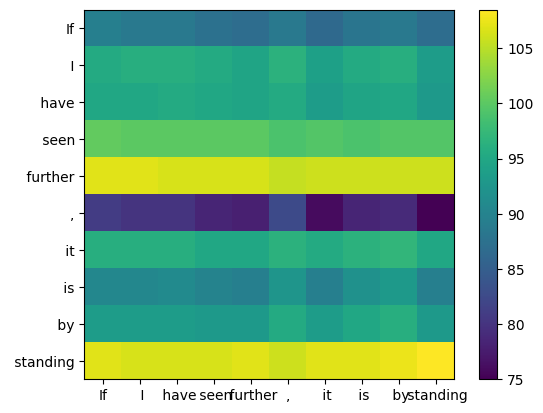

In [609]:
import matplotlib.pyplot as plt
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [610]:
# 做一个上三角为 -inf 的mask矩阵
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

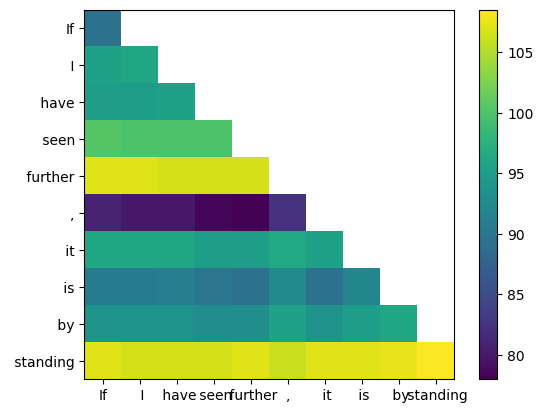

In [611]:
qk_per_token_after_masking = qk_per_token + mask   # 任何数和 -inf 相加，结果都仍是负无穷。这样在下一步做softmax的时候，负无穷就会被置0
display_qk_heatmap(qk_per_token_after_masking)

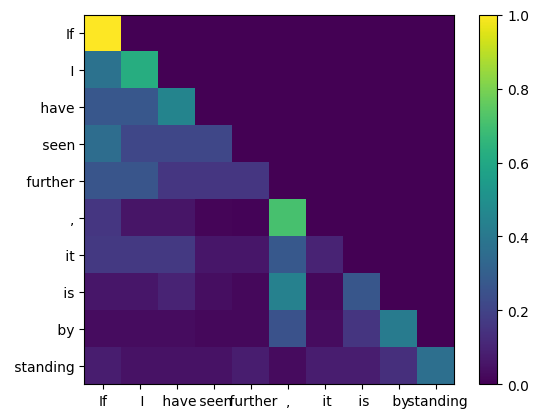

In [612]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

#### values (注意力之后的部分)
这些分数（0-1）用于确定每个 token 中使用了多少 value 矩阵。
<br>
&gt; 和 key 一样，value 权重也在每 7 个注意力头之间进行共享（以节省计算量，并且压缩kvcache的大小）
<br>
&gt; 因此，下面的 value 权重矩阵的 shape 为 [2x64x896]


In [613]:
v_layer0 = model["model.layers.0.self_attn.v_proj.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
print(v_layer0.shape)

v_layer0_bias = model["model.layers.0.self_attn.v_proj.bias"]
v_layer0_bias = v_layer0_bias.reshape(n_kv_heads, -1)
print(v_layer0_bias.shape)

torch.Size([2, 64, 896])
torch.Size([2, 64])


第一层第一个head的 value 和 bias

In [614]:
v_layer0_head0 = v_layer0[0]
v_layer0_bias_head0 = v_layer0_bias[0]
v_layer0_head0.shape, v_layer0_bias_head0.shape

(torch.Size([64, 896]), torch.Size([64]))

#### value 向量
现在使用 value 权重来获取每个 token 的注意力值，其大小为 [10x64]，其中 10 是 prompt 中的 token 数，64 是每个 tokene 的 value 向量的维度

In [615]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T) + v_layer0_bias_head0
v_per_token.shape

torch.Size([10, 64])

#### 注意力
和每个 token 的 value 相乘后得到的注意力向量的 shape 为 [10*64]

In [616]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([10, 64])

#### 多头注意力
我们现在已经有了第一层和第一个头的注意力值
<br>
现在我将运行一个循环，并执行与上面单元格中相同的数学运算，但只针对第一层中的每个头

In [617]:
qkv_attention_store = []
GQA_num = n_heads // n_kv_heads # 
for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//GQA_num] 
    v_layer0_head = v_layer0[head//GQA_num]
    q_layer0_bias_head = q_layer0_bias[head]
    k_layer0_bias_head = k_layer0_bias[head//GQA_num]
    v_layer0_bias_head = v_layer0_bias[head//GQA_num]
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T) + q_layer0_bias_head
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T) + k_layer0_bias_head
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T) + v_layer0_bias_head

    q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

14

现在我们有了第一个层的 14 个头的 qkv_attention 矩阵，接下来我将把所有注意力分数合并成一个大矩阵，大小为 [10x896]。

In [618]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([10, 896])

#### 权重矩阵，最后几步之一
对于第0层，最后要做的一件事是，将权重矩阵相乘。这个矩阵就是 attention 之后的 output 矩阵。

In [619]:
w_layer0 = model["model.layers.0.self_attn.o_proj.weight"]
w_layer0.shape

torch.Size([896, 896])

#### 这是一个简单的线性层，所以我们只需要进行乘法运算

In [620]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([10, 896])

注意力之后，我们现在有了嵌入值的变化，应该将其添加到原始的 token embeddings 中。就是 Transformer Layer 中的 shortcut 连接。

In [621]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([10, 896])

#### 我们将其归一化，然后运行一个前馈神经网络

In [622]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["model.layers.0.post_attention_layernorm.weight"])
embedding_after_edit_normalized.shape

torch.Size([10, 896])

#### 加载 FFN 权重并实现前馈网络
qwen2 使用了 SwiGLU 前馈网络，这种网络架构非常擅长非线性计算。
<br>
如今，在 LLMS 中使用这种前馈网络架构是相当常见的

In [623]:
w1 = model["model.layers.0.mlp.gate_proj.weight"]
w2 = model["model.layers.0.mlp.down_proj.weight"]
w3 = model["model.layers.0.mlp.up_proj.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([10, 896])

#### 第一层结束之后，我们得到每个 token 在第一层之后的结果，有了新的 embedding.
离我们结束还剩 23 层。
<br>
我们可以理解为，此处生成的 embedding 已经包含了每个token关于其他所有输入token的注意力查询信息，因为已经进行了一次自注意力计算。
<br>
现在，每一层都会对 query 进行越来越复杂的编码，直到我们得到一个 embedding，其中包含了我们需要的下一个 token 的所有信息。

现在通过for循环完成所有层的前向推理过程。之前为每一层所做的一切都需要一次性完成。

In [624]:
k_cache, v_cache = [], []   # init k v cache，为kvcache做准备，保存前向推理中生成的所有 keys 和 values.

In [625]:
final_embedding = token_embeddings_unnormalized
GQA_num = n_heads // n_kv_heads
for layer in range(n_layers):
    k_cache.append([])
    v_cache.append([])
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"model.layers.{layer}.input_layernorm.weight"])
    q_layer = model[f"model.layers.{layer}.self_attn.q_proj.weight"]
    q_layer = q_layer.reshape(n_heads, q_layer.shape[0] // n_heads, dim)
    q_layer_bias = model[f"model.layers.{layer}.self_attn.q_proj.bias"]
    q_layer_bias = q_layer_bias.reshape(n_heads, -1)
    k_layer = model[f"model.layers.{layer}.self_attn.k_proj.weight"]
    k_layer = k_layer.reshape(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    k_layer_bias = model[f"model.layers.{layer}.self_attn.k_proj.bias"]
    k_layer_bias = k_layer_bias.reshape(n_kv_heads, -1)
    v_layer = model[f"model.layers.{layer}.self_attn.v_proj.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    v_layer_bias = model[f"model.layers.{layer}.self_attn.v_proj.bias"]
    v_layer_bias = v_layer_bias.reshape(n_kv_heads, -1)
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//GQA_num]
        v_layer_head = v_layer[head//GQA_num]
        q_layer_bias_head = q_layer_bias[head]
        k_layer_bias_head = k_layer_bias[head//GQA_num]
        v_layer_bias_head = v_layer_bias[head//GQA_num]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T) + q_layer_bias_head
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T) + k_layer_bias_head
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T) + v_layer_bias_head
        if head % GQA_num == 0:   # 
            v_cache[-1].append(v_per_token)   # cache v vector
        q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin)   
        if head % GQA_num == 0:   # 
            k_cache[-1].append(k_per_token_rotated)  # cache k vector
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"model.layers.{layer}.self_attn.o_proj.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"model.layers.{layer}.post_attention_layernorm.weight"])
    w1 = model[f"model.layers.{layer}.mlp.gate_proj.weight"]
    w2 = model[f"model.layers.{layer}.mlp.down_proj.weight"]
    w3 = model[f"model.layers.{layer}.mlp.up_proj.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

In [626]:
# k v cache info
print(k_cache[0][0].shape)
print(k_cache[0][-1].shape)
print(len(k_cache))
print(len(k_cache[0]))
print(v_cache[0][0].shape)
print(v_cache[0][-1].shape)
print(len(v_cache))
print(len(v_cache[0]))

torch.Size([10, 64])
torch.Size([10, 64])
24
2
torch.Size([10, 64])
torch.Size([10, 64])
24
2


#### 我们现在有了最终的 embedding，模型可以对下一个 token 做出的最优猜测
embedding 的 shape 与常规 token embedding [10x896] 相同，其中 10 是 token 数量，896 是 embedding 维度。
<br>
注意：在 Transformer Layer 前向推理过程中，是不会改变 token 的 embedding 的维度的。

In [627]:
final_embedding = rms_norm(final_embedding, model["model.norm.weight"])   # 先做一次归一化。这里的归一化是最后进行的一次，不属于任何一个层。
final_embedding.shape

torch.Size([10, 896])

我们将使用 output decoder 将最终 embedding 转换为 token. 
<br>
但是 qwen2-0.5b 的 config 文件中有一个 tie_word_embeddings 参数且为 true，意思是将 output layer 与 embedding 层进行权重绑定，也就共享权重。
<br>
所以这里仍然加载的是 embedding 的权重, 不共享的模型则有单独的 output layer 层的权重，如 qwen2-7b 等。权重共享有利于节省参数，对于小模型尤其重要。

In [628]:
model["model.embed_tokens.weight"].shape

torch.Size([151936, 896])

#### 我们使用最后一个 token 的 embedding 来预测下一个值

In [629]:
logits = torch.matmul(final_embedding[-1], model["model.embed_tokens.weight"].T)   # 一个简单的线性矩阵乘法
logits.shape

torch.Size([151936])

#### 模型预测的 token 编号是 389，这是否代表 ' on' 的 token 编号？

In [630]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(389)

解码输出

In [631]:
tokenizer.decode([next_token.item()])

' on'

#### 预填充阶段推理完成
生成第一个预测的 token 且缓存了推理过程中生成的 keys 和 values。下一阶段进行decoder自回归推理，加载前面生成的 k 和 v，避免重复计算，加速推理过程。

In [632]:
max_new_len = 6   # 设置最大生成 token 数
seq_len = len(tokens)
GQA_num = n_heads // n_kv_heads 

In [633]:
next_token = torch.tensor([next_token.item()])
for _ in range(max_new_len-1):
    print(next_token[-1].item())
    if next_token.item() == 151643:    # 151643 is "<|end_of_text|>"
        break
    next_token = next_token[-1:]
    next_token_embeddings_unnormalized = embedding_layer(next_token).to(torch.bfloat16)

    final_embedding = next_token_embeddings_unnormalized
    for layer in range(n_layers):
        qkv_attention_store = []
        layer_embedding_norm = rms_norm(final_embedding, model[f"model.layers.{layer}.input_layernorm.weight"])
        q_layer = model[f"model.layers.{layer}.self_attn.q_proj.weight"]
        q_layer = q_layer.reshape(n_heads, q_layer.shape[0] // n_heads, dim)
        q_layer_bias = model[f"model.layers.{layer}.self_attn.q_proj.bias"]
        q_layer_bias = q_layer_bias.reshape(n_heads, -1)
        k_layer = model[f"model.layers.{layer}.self_attn.k_proj.weight"]
        k_layer = k_layer.reshape(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
        k_layer_bias = model[f"model.layers.{layer}.self_attn.k_proj.bias"]
        k_layer_bias = k_layer_bias.reshape(n_kv_heads, -1)
        v_layer = model[f"model.layers.{layer}.self_attn.v_proj.weight"]
        v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
        v_layer_bias = model[f"model.layers.{layer}.self_attn.v_proj.bias"]
        v_layer_bias = v_layer_bias.reshape(n_kv_heads, -1)
        for head in range(n_heads):
            q_layer_head = q_layer[head]
            k_layer_head = k_layer[head//GQA_num]
            v_layer_head = v_layer[head//GQA_num]
            q_layer_bias_head = q_layer_bias[head]
            k_layer_bias_head = k_layer_bias[head//GQA_num]
            v_layer_bias_head = v_layer_bias[head//GQA_num]
            q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T) + q_layer_bias_head
            
            cos, sin = rotary_emb(torch.tensor([seq_len]))
            q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin)

            if head % GQA_num == 0:
                v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T) + v_layer_bias_head
                v_cache[layer][head//GQA_num] = torch.cat([v_cache[layer][head//GQA_num], v_per_token], dim=0)    # update v_cache

                k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T) + k_layer_bias_head 
                q_per_token_rotated, k_per_token_rotated = apply_rotary_pos_emb(q_per_token, k_per_token, cos, sin)
                k_cache[layer][head//GQA_num] = torch.cat([k_cache[layer][head//GQA_num], k_per_token_rotated], dim=0)    # update k_cache
                
            qk_per_token = torch.matmul(q_per_token_rotated, k_cache[layer][head//GQA_num].T)/(head_dim)**0.5
            # mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))   # 使用 kvcache 不再需要 mask
            # mask = torch.triu(mask, diagonal=1)
            qk_per_token_after_masking = qk_per_token  # + mask
            qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
            qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_cache[layer][head//GQA_num])
            qkv_attention_store.append(qkv_attention)

        stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
        w_layer = model[f"model.layers.{layer}.self_attn.o_proj.weight"]
        embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
        embedding_after_edit = final_embedding + embedding_delta
        embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"model.layers.{layer}.post_attention_layernorm.weight"])
        w1 = model[f"model.layers.{layer}.mlp.gate_proj.weight"] 
        w2 = model[f"model.layers.{layer}.mlp.down_proj.weight"]
        w3 = model[f"model.layers.{layer}.mlp.up_proj.weight"]
        output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
        final_embedding = embedding_after_edit+output_after_feedforward
    
    final_embedding = rms_norm(final_embedding, model["model.norm.weight"])
    logits = torch.matmul(final_embedding, model["model.embed_tokens.weight"].T)
    next_token = torch.argmax(logits, dim=-1)
    print("token decode: ", tokenizer.decode([next_token.item()]))
    seq_len += 1

389
token decode:   the
279
token decode:   shoulders
26906
token decode:   of
315
token decode:   giants
45209
token decode:  .


#### 完结